# Adversarial Simple Spread - DQN

Agent observations: `[self_is_adversary, self_vel, self_pos, landmark_rel_positions, other_agent_is_adversary_rel_positions]`
 - `self_is_adversary = (1, )`: 0 / 1 flag
 - `self_vel = (2, )`
 - `self_pos = (2, )`
 - `landmark_rel_positions = (2 * n_landmarks, )`
 - `other_agent_is_adversary_rel_positions = ((1 + 2) * (n_agents + n_adversaries - 1), )`: 0 / 1 flag  for if that other agent is an adversary + relative position for the other agent times the number of other agents

Agent action space: `[no_action, move_left, move_right, move_down, move_up] = (0-4)` 

In [3]:
%load_ext autoreload
%autoreload 2

from collections import namedtuple
import imageio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import simple_spread_adversarial

# Set up matplotlib:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Detect if GPU is available:
DEVICE = torch.device(
    "mps" if torch.backends.mps.is_available()
    else (
        "cuda" if torch.cuda.is_available()
        else "cpu"
    )
)

# Global params:
GAMMA = 0.99  # < 1 to encourage prioritization of immediate rewards


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Up Environment

In [4]:
# Set up environment
n_adv = 1  # For basic testing, same N for all params
n_good = 1
n_landm = 1


env = simple_spread_adversarial.parallel_env(n_agents=n_adv, n_adversaries=n_good, n_landmarks=n_landm)

observations, _ = env.reset()
observation_dim = observations["agent_0"].shape[0]
num_actions = env.action_space("agent_0").n

print("num_agents = ", env.num_agents, env.agents)
print(f"{num_actions=}")
print(f"{observation_dim=}")

observations

num_agents =  2 ['adversary_0', 'agent_0']
num_actions=5
observation_dim=10


{'adversary_0': array([ 1.        ,  0.        ,  0.        , -0.47933534,  0.28412634,
         1.2472441 , -1.251474  ,  0.        ,  1.4386747 , -0.27760366],
       dtype=float32),
 'agent_0': array([ 0.        ,  0.        ,  0.        ,  0.9593394 ,  0.00652266,
        -0.19143063, -0.9738704 ,  1.        , -1.4386747 ,  0.27760366],
       dtype=float32)}

## Helpers

In [5]:
class DQN(nn.Module):
    def __init__(
            self,
            input_dim=observation_dim,
            layers=[],
            output_dim=num_actions,
            activation_function="ReLU",
            loss_function="huber_loss",
            **kwargs
        ):
        super().__init__()

        # Validate Inputs:
        assert len(layers) > 0

        if type(activation_function) == str:
            assert(activation_function in nn.__dict__), (
                "activation_function must be one of the activation functions " +
                "available in the torch.nn module, e.g. 'ReLU'"
            )
            activation_function = nn.__dict__[activation_function]
        
        if type(loss_function) == str:
            assert(loss_function in F.__dict__), (
                "loss_function must be one of the loss functions " +
                "available in the torch.nn.functional module, e.g. 'cross_entropy'"
            )
            loss_function = F.__dict__[loss_function]

        # ------------------------------
        # Actually Initialize the Model:
        # ------------------------------
        self.layers = nn.ModuleList()

        # Hidden MLP Layers:
        for i, layer_size in enumerate(layers):
            if i == 0:
                layer_in = input_dim
            else:
                layer_in = layers[i - 1]

            layer = nn.Sequential(
                nn.Linear(layer_in, layer_size),
                activation_function()
            )
            self.layers.append(layer)

        # Final Fully Connected Output Layer:
        self.layers.append(nn.Linear(layers[-1], output_dim))
        
        # Loss:
        self.loss_function = loss_function

    def copy_weights(self, other_model):
        self.load_state_dict(other_model.state_dict())

    def forward(self, X, targets=None):
        for layer in self.layers:
            X = layer(X)

        # Final layer's output is the logits:
        logits = X

        if targets is not None:
            loss = self.loss_function(logits, targets)
            return logits, loss
        else:
            return logits

# Models objects for holding all the models for an agent:
Models = namedtuple("Models", ["main", "target"])

def _initialize_models(model_size):
    # Model used for selecting actions (principal)
    model = DQN(layers=[model_size] * 2).to(DEVICE)
    
    # Then create the target model. This will periodically be copied from the principal network 
    target_model = DQN(layers=[model_size] * 2).to(DEVICE)

    # Make sure models are initialized identically:
    target_model.copy_weights(model)

    return Models(model, target_model)

def initialize_models(env, model_size):
    env.reset()  # Reset env to make sure agent list isn't empty
    return {agent: _initialize_models(model_size) for agent in env.agents}

def select_actions(env, observations, models, epsilon):
    # Epsilon greedy
    if np.random.random() < epsilon:
        # Take random actions:
        actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    else:
        # Predict action Q-values
        # From environment observations
        actions = {}
        for agent, model in models.items():
            model.main.eval()
            actions[agent] = model.main(
                # Observation (state) as tensor
                torch.tensor(observations[agent]).to(DEVICE)
            ).argmax(dim=-1).item()
    
    return actions

class ReplayBuffer():
    def __init__(
            self,
            max_size,
            state_dim=observation_dim,
            action_dim=1,
            reward_dim=1,
        ):
        self.history = []
        self.max_size = max_size
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.reward_dim = reward_dim
    
    @property
    def size(self):
        return len(self.history)
    
    def states(self, i):
        return self.history[i, :self.state_dim]

    def actions(self, i):
        return self.history[i, self.state_dim:(self.state_dim + self.action_dim)]

    def rewards(self, i):
        return self.history[
            i,
            (self.state_dim + self.action_dim)
            :(self.state_dim + self.action_dim + self.reward_dim)
        ]

    def state_nexts(self, i):
        return self.history[i, -self.state_dim:]
    
    def store(self, state, action, reward, state_next):
        if self.action_dim == 1: action = [action]
        if self.reward_dim == 1: reward = [reward]

        SARS = np.concatenate(
            [state, action, reward, state_next],
            dtype="float32"
        ).reshape(1, -1)

        if self.size == 0:
            self.history = SARS
        else:
            self.history = np.concatenate([self.history, SARS], axis=0)
    
        # Don't let the memory grow beyond the limit
        if self.size > self.max_size:
            self.history = self.history[1:]

    def sample(self, n):
        #  Sample a set of batch_size memories from the history
        sample_ids = np.random.choice(
            np.arange(self.size), size=n, replace=False
        )

        states = torch.tensor(self.states(sample_ids)).to(DEVICE)
        actions = torch.tensor(self.actions(sample_ids)).to(DEVICE)
        rewards = torch.tensor(self.rewards(sample_ids)).to(DEVICE)
        state_nexts = torch.tensor(self.state_nexts(sample_ids)).to(DEVICE)

        return states, actions, rewards, state_nexts

def train_one_step(models, memories, optimizers, batch_size=128):
    losses = {}

    for agent, model in models.items():
        #  Sample a set of batch_size memories from the history
        states, actions, rewards, state_nexts = memories[agent].sample(batch_size)

        # Create for the sample states the targets (r+gamma * max Q(...) )
        model.target.eval()
        Q_next_state = model.target(state_nexts)
        Q_targets = rewards + GAMMA * Q_next_state.max(axis=-1).values.view(-1, 1)

        # Q values to train:
        model.main.train()
        Q_values = model.main(states)
        # Pluck out the relevant actions only
        Q_of_actions = Q_values.gather(1, actions.to(int))

        # Calculate loss and perform optimization step:
        loss = model.main.loss_function(Q_of_actions, Q_targets)
        optimizers[agent].zero_grad()
        loss.backward()
        optimizers[agent].step()

        losses[agent] = loss.item()
    
    return losses

# Build validation dateset of held out states for use in tracking avg. max Q as
# a training validation / debugging metric:
def generate_validation_data(env=env, n=100):
    env.reset()  # Reset env to make sure agent list isn't empty
    validation_data = {agent: [] for agent in env.agents}

    for episode in range(n):
        observations, _ = env.reset()

        while env.agents:
            for agent in env.agents:
                validation_data[agent].append(observations[agent])

            # Take random actions:
            actions = {agent: env.action_space(agent).sample() for agent in env.agents}
            # Follow selected actions:
            observations, _, _, _, _ = env.step(actions)

    env.reset()  # Reset env to make sure agent list isn't empty
    validation_data = {
        agent: torch.tensor(np.array(validation_data[agent])).to(DEVICE)
        for agent in env.agents
    }
    return validation_data

def calc_avg_max_Q(models, validation_data):
    avg_max_Qs = {}
    for agent, model in models.items():
        model.main.eval()
        avg_max_Qs[agent] =\
            model.main(validation_data[agent]).max(axis=-1).values.mean().item()
    
    return avg_max_Qs


## Validation Set Up

In [6]:
validation_data = generate_validation_data(env=env, n=100)

## Training Loop

In [7]:
# ==============================================================================
# KEY PARAMS:
model_size = 128
batch_size = 128
learning_rate = 5e-4
max_episodes = 5000
max_memory = 10000  # Replay memory size
# how often to train your model - this allows you to speed up learning
# by not performing in every iteration learning. See also refernece paper
# you can set this value to other values like 1 as well to learn every time 
update_after_actions = 4
target_update_every = 1000  # How often to update the target network
epsilon = 0.1
# ==============================================================================

# Initialize models:
models = initialize_models(env, model_size)
optimizers = {
    agent: optim.Adam(model.main.parameters(), lr=learning_rate)
    for agent, model in models.items()
}

# Our Experience Replay memory (state, action, reward, next state)
env.reset()  # Reset env to make sure agent list isn't empty
memories = {agent: ReplayBuffer(max_memory) for agent in env.agents}
episode_reward_history = {agent: [] for agent in env.agents}
loss_history = {agent: [] for agent in env.agents}
avg_max_Q_history = {agent: [] for agent in env.agents}

# Tracking values
running_rewards = {agent: 0 for agent in env.agents}
episode_count = 0
timestep_count = 0

# Training Loop
for episode in range(max_episodes):
    observations, _ = env.reset()
    episode_rewards = {agent: 0 for agent in env.agents}

    while env.agents:
        timestep_count += 1
        actions = select_actions(env, observations, models, epsilon)

        # Follow selected actions
        observations_next, rewards, _, _, _ = env.step(actions)
        
        # Save action results
        for agent in rewards.keys():
            episode_rewards[agent] += rewards[agent]

            # Save action/states and other information in replay buffer
            memories[agent].store(
                observations[agent],
                actions[agent],
                rewards[agent],
                observations_next[agent]
            )

        observations = observations_next

        # Update every Xth frame to speed up (optional)
        # and if you have sufficient history
        if timestep_count % update_after_actions == 0 and timestep_count > batch_size:
            losses = train_one_step(models, memories, optimizers, batch_size)
            for agent, loss in losses.items():
                loss_history[agent].append(loss)

        if timestep_count % target_update_every == 0:
            # Update the the target network with new weights
            for model in models.values():
                model.target.copy_weights(model.main)

    # Record tracking statistics:
    for agent, episode_reward in episode_rewards.items():
        episode_reward_history[agent].append(episode_reward)
    
    for agent, avg_max_Q in calc_avg_max_Q(models, validation_data).items():
        avg_max_Q_history[agent].append(avg_max_Q)

    episode_count += 1

    # Logging:
    if episode_count % 50 == 0:
        # Log details
        # average reward of last 100:
        running_rewards = {
            agent: np.mean(episode_reward_history[agent][-100:])
            for agent in running_rewards.keys()
        }
        template = "running rewards: {} at episode {}, timestep {}, epsilon {}"
        print(template.format(running_rewards, episode_count, timestep_count, epsilon))


running rewards: {'adversary_0': 0.34, 'agent_0': -35.48618038247948} at episode 50, timestep 1250, epsilon 0.1
running rewards: {'adversary_0': 0.34, 'agent_0': -33.88211967063644} at episode 100, timestep 2500, epsilon 0.1
running rewards: {'adversary_0': 0.38, 'agent_0': -27.908304610100885} at episode 150, timestep 3750, epsilon 0.1
running rewards: {'adversary_0': 0.64, 'agent_0': -19.023064241775458} at episode 200, timestep 5000, epsilon 0.1


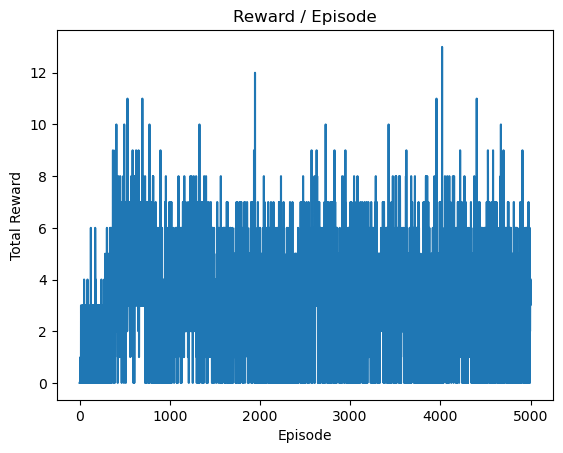

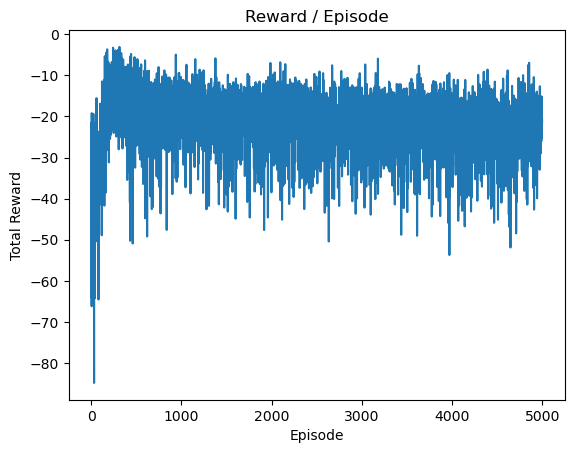

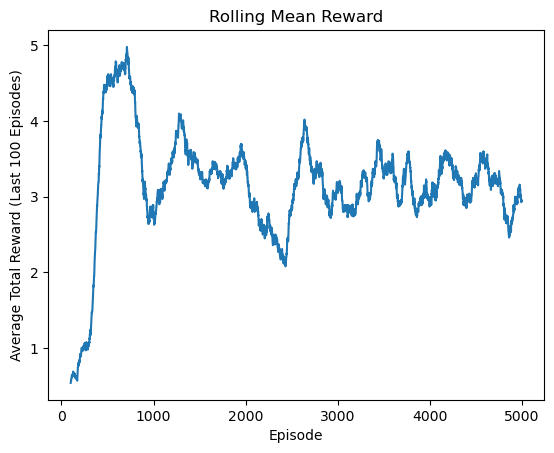

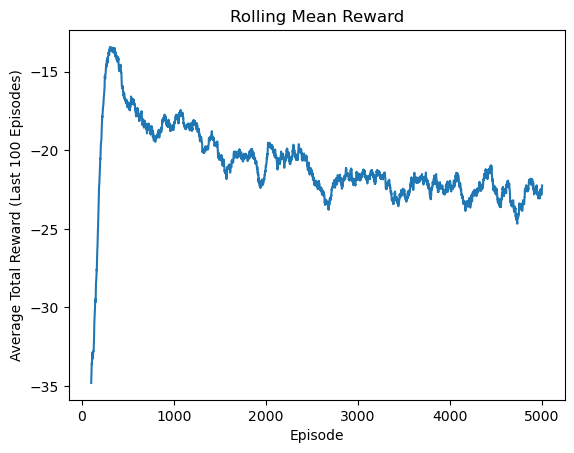

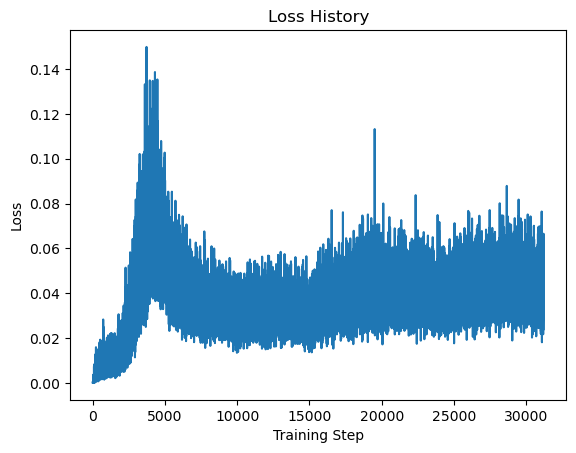

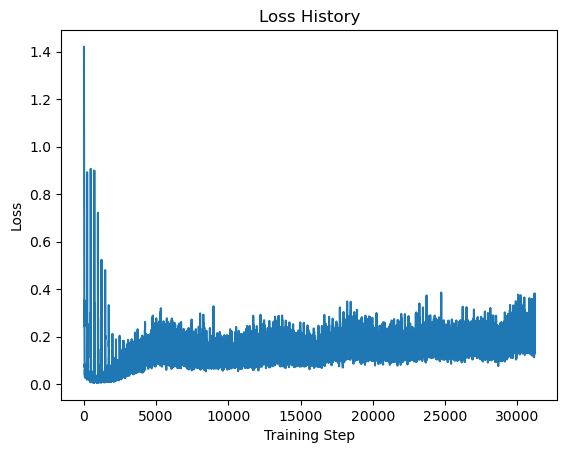

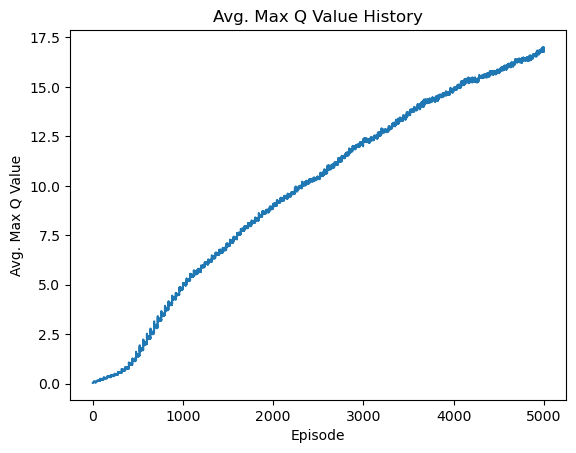

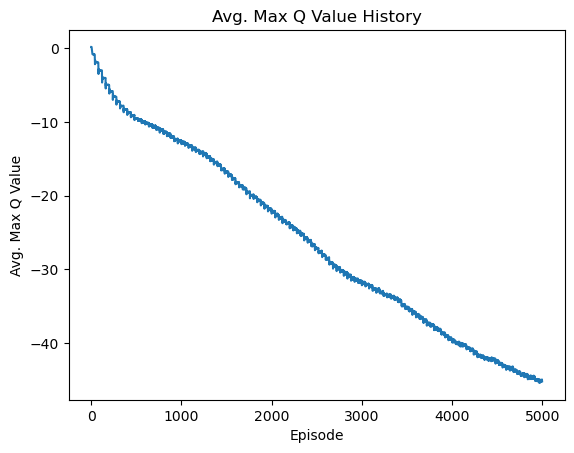

In [ ]:
# Training Plots (for Debugging)
env.reset()  # Reset env to make sure agent list isn't empty

for agent in env.agents:
    # Raw Reward
    plt.title(f"{agent}: Reward / Episode")
#     plt.title("Reward / Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.plot(np.arange(len(episode_reward_history[agent])), episode_reward_history[agent])
    plt.show()

# Rolling Average Reward:
def moving_average(x, w):
    # Source: https://stackoverflow.com/a/54628145
    return np.convolve(x, np.ones(w), 'valid') / w

for agent in env.agents:
    rolling_means = moving_average(episode_reward_history[agent], 100)

    # Rolling Average
    plt.title("Rolling Mean Reward")
    plt.xlabel("Episode") 
    plt.ylabel("Average Total Reward (Last 100 Episodes)")
    plt.plot(np.arange(len(rolling_means)) + 100, rolling_means)
    plt.show()

for agent in env.agents:
    # Loss Trend
    plt.title("Loss History")
    plt.xlabel("Training Step") 
    plt.ylabel("Loss")
    plt.plot(np.arange(len(loss_history[agent])), loss_history[agent])
    plt.show()

for agent in env.agents:
    # Avg. Max Q Trend
    plt.title("Avg. Max Q Value History")
    plt.xlabel("Episode") 
    plt.ylabel("Avg. Max Q Value")
    plt.plot(np.arange(len(avg_max_Q_history[agent])), avg_max_Q_history[agent])
    plt.show()


## Final Evaluation

In [ ]:
def eval_greedy_model(env, models):
    env.reset()  # Reset env to make sure agent list isn't empty

    # Tracking values
    final_eval_rewards = {agent: [] for agent in env.agents}

    for episode in range(100):
        observations, _ = env.reset()
        episode_rewards = {agent: 0 for agent in env.agents}

        while env.agents:
            actions = select_actions(env, observations, models, epsilon=0)

            # Follow selected actions
            observations_next, rewards, _, _, _ = env.step(actions)
            
            # Save action results
            for agent in rewards.keys():
                episode_rewards[agent] += rewards[agent]

            observations = observations_next

        # Record tracking statistics:
        for agent, episode_reward in episode_rewards.items():
            final_eval_rewards[agent].append(episode_reward)


    avg_greedy_reward = {
        agent: np.mean(final_eval_reward)
        for agent, final_eval_reward in final_eval_rewards.items()
    }

    return avg_greedy_reward, final_eval_rewards


{'adversary_0': 2.72, 'agent_0': -21.780224509108425}


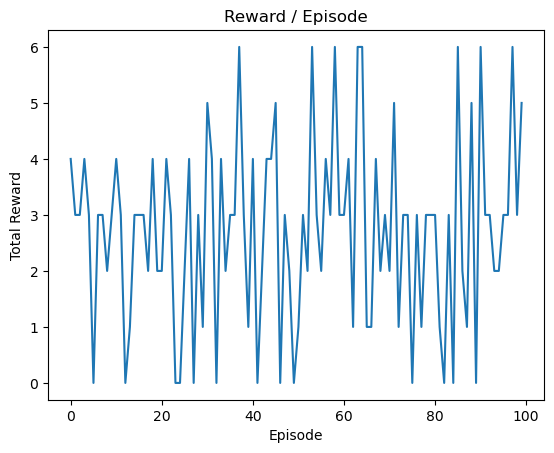

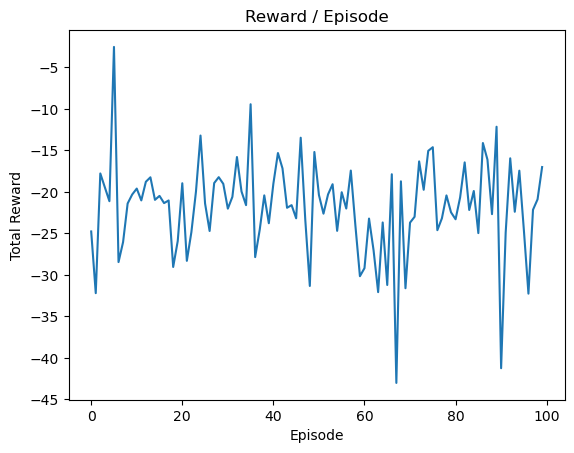

In [ ]:
avg_greedy_reward, final_eval_rewards = eval_greedy_model(env, models)

print(avg_greedy_reward)

env.reset()  # Reset env to make sure agent list isn't empty

for agent in env.agents:
    # Raw Reward
    plt.title("Reward / Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.plot(np.arange(len(final_eval_rewards[agent])), final_eval_rewards[agent])
    plt.show()
    plt.savefig(f'final_run_graphs/adv-{n_adv}_good-{n_good}_lm-{n_landm}.png')
    

In [ ]:
# Visualize full episode
rendered_env = simple_spread_adversarial.parallel_env(
    n_agents=N,
    n_adversaries=N,
    n_landmarks=N,
    render_mode="rgb_array"
)
frames = []

observations, _ = rendered_env.reset()
frames.append(rendered_env.render())

while rendered_env.agents:
    # this is where you would insert your policy
    actions = select_actions(rendered_env, observations, models, epsilon=0)

    observations, _, _, _, _ = rendered_env.step(actions)
    frames.append(rendered_env.render())

rendered_env.close()

imageio.mimwrite(
    "rendered_episode.gif",
    frames,
    loop=0  # Infinite loop gif
)
